In [1]:
import numpy as np
import pandas as pd
import re

# Plotting and Metrics imports
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Data Processing imports
from sklearn.model_selection import train_test_split
import re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')

# Feature Extraction imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Doc2Vec imports
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Models imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier



## Fake or Real News dataset

In [2]:
# Load the data
for_df = pd.read_csv('01fakeorrealnews/news.csv')

# Splitting the data into training and validation sets (80% training, 20% validation)
for_train, for_valid = train_test_split(for_df, test_size=0.2, stratify=for_df['label'], random_state=27)

for_train = for_train[['text', 'label']]
for_valid = for_valid[['text', 'label']]

# Rename the columns
for_train = for_train.rename(columns={'text': 'Statement', 'label': 'Label'})
for_valid = for_valid.rename(columns={'text': 'Statement', 'label': 'Label'})

#### Study the dataset

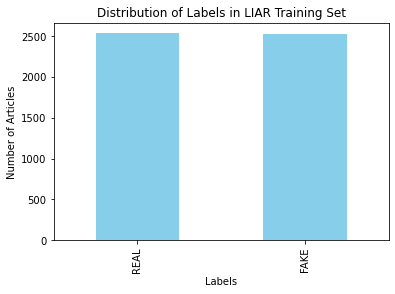

In [3]:
# Distribution
# Plotting the distribution of labels in the training set
for_train['Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels Training Set')
plt.xlabel('Labels')
plt.ylabel('Number of Articles')
plt.show()

In [4]:
# Missing value
# Display the number of missing values for each column in the training set
missing_values = for_train.isnull().sum()
print("Missing values in LIAR Training Set:")
print(missing_values)


Missing values in LIAR Training Set:
Statement    0
Label        0
dtype: int64


### Data Preprocessing

In [5]:
# Data Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove stopwords and lemmatize
    text = ' '.join(lemmatizer.lemmatize(token) for token in text.split() if token not in stop_words)
    return text

for_train['Statement'] = for_train['Statement'].apply(normalize_text)
for_valid['Statement'] = for_valid['Statement'].apply(normalize_text)

In [6]:
print(for_train.head())

                                              Statement Label
3369  grossly generalistic could put half trump supp...  REAL
1724  former president bill clinton might want keep ...  REAL
2053  donald trump presented dark picture country co...  REAL
1259  bernie sander strength among white men pinched...  REAL
4832  cnn saturday big day bernie sander quest democ...  REAL


In [7]:
# BoW

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=5000)  # Limiting to 5000 most frequent words for simplicity

# Fit and transform the training data from LIAR dataset
X_train_bow = vectorizer.fit_transform(for_train['Statement'])

# Transform the validation　data
X_valid_bow = vectorizer.transform(for_valid['Statement'])

# Print some information
print(f"Shape of BoW training data: {X_train_bow.shape}")
print(f"Shape of BoW validation data: {X_valid_bow.shape}")

y_train = for_train['Label']
y_valid = for_valid['Label']


Shape of BoW training data: (5068, 5000)
Shape of BoW validation data: (1267, 5000)


In [8]:
# BoW + Decision Tree
# Initialize the Decision Tree Classifier
clf_tree = DecisionTreeClassifier()

# Train the classifier using the training data
clf_tree.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_tree = clf_tree.predict(X_valid_bow)

# Evaluate the performance
accuracy_tree = accuracy_score(y_valid, y_pred_tree)
print(f"Validation Accuracy: {accuracy_tree * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_tree))


Validation Accuracy: 79.87%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.79      0.82      0.80       633
        REAL       0.81      0.78      0.80       634

    accuracy                           0.80      1267
   macro avg       0.80      0.80      0.80      1267
weighted avg       0.80      0.80      0.80      1267



In [9]:
# BoW + Random Froest
# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier()

# Train the classifier using the training data
clf_rf.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_bow)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 90.06%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.91      0.89      0.90       633
        REAL       0.89      0.91      0.90       634

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



In [10]:
#BoW + SVM
# Initialize the SVM Classifier
clf_svm_bow = SVC(kernel='linear', probability=True)

# Train the classifier using the BoW training data
clf_svm_bow.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_svm_bow = clf_svm_bow.predict(X_valid_bow)

# Evaluate the performance
accuracy_svm_bow = accuracy_score(y_valid, y_pred_svm_bow)
print(f"Validation Accuracy for SVM with BoW: {accuracy_svm_bow * 100:.2f}%\n")
print("Classification Report for SVM with BoW:")
print(classification_report(y_valid, y_pred_svm_bow))


Validation Accuracy for SVM with BoW: 85.95%

Classification Report for SVM with BoW:
              precision    recall  f1-score   support

        FAKE       0.86      0.86      0.86       633
        REAL       0.86      0.86      0.86       634

    accuracy                           0.86      1267
   macro avg       0.86      0.86      0.86      1267
weighted avg       0.86      0.86      0.86      1267



In [11]:
#BoW + KNN neighbours 5
# Initialize the KNN Classifier
clf_knn_bow = KNeighborsClassifier(n_neighbors=5)  # You can tune the 'n_neighbors' parameter

# Train the classifier using the BoW training data
clf_knn_bow.fit(X_train_bow, y_train)

# Predict on the validation set
y_pred_knn_bow = clf_knn_bow.predict(X_valid_bow)

# Evaluate the performance
accuracy_knn_bow = accuracy_score(y_valid, y_pred_knn_bow)
print(f"Validation Accuracy for KNN with BoW: {accuracy_knn_bow * 100:.2f}%\n")
print("Classification Report for KNN with BoW:")
print(classification_report(y_valid, y_pred_knn_bow))


Validation Accuracy for KNN with BoW: 80.74%

Classification Report for KNN with BoW:
              precision    recall  f1-score   support

        FAKE       0.78      0.87      0.82       633
        REAL       0.85      0.75      0.80       634

    accuracy                           0.81      1267
   macro avg       0.81      0.81      0.81      1267
weighted avg       0.81      0.81      0.81      1267



In [12]:
# Feature Extraction TF-IDF

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(for_train['Statement'])

# Transform the validation data
X_valid_tfidf = tfidf_vectorizer.transform(for_valid['Statement'])


In [13]:
# TF-IDF + Decision Tree
# Initialize the Decision Tree Classifier
clf_tree_tfidf = DecisionTreeClassifier()

# Train the classifier using the training data
clf_tree_tfidf.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_tree_tfidf = clf_tree_tfidf.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_tree_tfidf = accuracy_score(y_valid, y_pred_tree_tfidf)
print(f"Validation Accuracy: {accuracy_tree_tfidf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_tree_tfidf))


Validation Accuracy: 80.35%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.80      0.80      0.80       633
        REAL       0.80      0.80      0.80       634

    accuracy                           0.80      1267
   macro avg       0.80      0.80      0.80      1267
weighted avg       0.80      0.80      0.80      1267



In [14]:
# TF-IDF + random forest
# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100)

# Train the classifier using the training data
clf_rf.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 90.92%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.90      0.91      0.91       633
        REAL       0.91      0.90      0.91       634

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



In [15]:
# TF-IDF + SVM
# Initialize the SVC classifier with a linear kernel
clf_svc = SVC(kernel='linear')

# Train the classifier using the training data
clf_svc.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_svc = clf_svc.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_svc = accuracy_score(y_valid, y_pred_svc)
print(f"Validation Accuracy: {accuracy_svc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_svc))


Validation Accuracy: 91.40%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.90      0.93      0.92       633
        REAL       0.93      0.90      0.91       634

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



In [16]:
# TF-IDF + KNN neighbours 5 
# Initialize the KNN classifier
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
clf_knn.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_pred_knn = clf_knn.predict(X_valid_tfidf)

# Evaluate the performance
accuracy_knn = accuracy_score(y_valid, y_pred_knn)
print(f"Validation Accuracy: {accuracy_knn * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_knn))


Validation Accuracy: 64.33%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.58      0.99      0.74       633
        REAL       0.97      0.30      0.45       634

    accuracy                           0.64      1267
   macro avg       0.78      0.64      0.59      1267
weighted avg       0.78      0.64      0.59      1267



In [17]:
# N-grams Representation

# Initialize CountVectorizer with ngram range for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
X_train_ngram = vectorizer.fit_transform(for_train['Statement'])

# Transform the validation data
X_valid_ngram = vectorizer.transform(for_valid['Statement'])

# Now you can train your models on the X_train_ngram and evaluate on X_valid_ngram


In [18]:
# N-grams + Decision Tree

# Initialize the Decision Tree Classifier
clf_tree_ngram = DecisionTreeClassifier()

# Train the classifier using the n-gram training data
clf_tree_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_tree_ngram = clf_tree_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_tree_ngram = accuracy_score(y_valid, y_pred_tree_ngram)
print(f"Validation Accuracy using n-grams: {accuracy_tree_ngram * 100:.2f}%\n")
print("Classification Report for n-grams:")
print(classification_report(y_valid, y_pred_tree_ngram))


Validation Accuracy using n-grams: 83.11%

Classification Report for n-grams:
              precision    recall  f1-score   support

        FAKE       0.84      0.82      0.83       633
        REAL       0.83      0.84      0.83       634

    accuracy                           0.83      1267
   macro avg       0.83      0.83      0.83      1267
weighted avg       0.83      0.83      0.83      1267



In [19]:
# N-gram + Random Forest

# Initialize the Random Forest Classifier
clf_rf_ngram = RandomForestClassifier()

# Train the classifier using the n-gram training data
clf_rf_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_rf_ngram = clf_rf_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_rf_ngram = accuracy_score(y_valid, y_pred_rf_ngram)
print(f"Validation Accuracy using n-grams with Random Forest: {accuracy_rf_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with Random Forest:")
print(classification_report(y_valid, y_pred_rf_ngram))


Validation Accuracy using n-grams with Random Forest: 86.03%

Classification Report for n-grams with Random Forest:
              precision    recall  f1-score   support

        FAKE       0.86      0.86      0.86       633
        REAL       0.86      0.86      0.86       634

    accuracy                           0.86      1267
   macro avg       0.86      0.86      0.86      1267
weighted avg       0.86      0.86      0.86      1267



In [20]:
# N-grams + SVM

# Initialize the SVM classifier with a linear kernel
clf_svm_ngram = SVC(kernel='linear')

# Train the classifier using the n-gram training data
clf_svm_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_svm_ngram = clf_svm_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_svm_ngram = accuracy_score(y_valid, y_pred_svm_ngram)
print(f"Validation Accuracy using n-grams with SVM: {accuracy_svm_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with SVM:")
print(classification_report(y_valid, y_pred_svm_ngram))


Validation Accuracy using n-grams with SVM: 86.50%

Classification Report for n-grams with SVM:
              precision    recall  f1-score   support

        FAKE       0.85      0.89      0.87       633
        REAL       0.88      0.84      0.86       634

    accuracy                           0.87      1267
   macro avg       0.87      0.87      0.86      1267
weighted avg       0.87      0.87      0.86      1267



In [21]:
# N-gram + k-NN 5

# Initialize the KNN classifier with 5 neighbors
clf_knn_ngram = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the n-gram training data
clf_knn_ngram.fit(X_train_ngram, y_train)

# Predict on the validation set
y_pred_knn_ngram = clf_knn_ngram.predict(X_valid_ngram)

# Evaluate the performance
accuracy_knn_ngram = accuracy_score(y_valid, y_pred_knn_ngram)
print(f"Validation Accuracy using n-grams with KNN: {accuracy_knn_ngram * 100:.2f}%\n")
print("Classification Report for n-grams with KNN:")
print(classification_report(y_valid, y_pred_knn_ngram))


Validation Accuracy using n-grams with KNN: 75.93%

Classification Report for n-grams with KNN:
              precision    recall  f1-score   support

        FAKE       0.73      0.83      0.77       633
        REAL       0.80      0.69      0.74       634

    accuracy                           0.76      1267
   macro avg       0.76      0.76      0.76      1267
weighted avg       0.76      0.76      0.76      1267



In [22]:
# Doc2Vec

articles_tokenized = [word_tokenize(article.lower()) for article in for_train['Statement']]

tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(articles_tokenized)]

model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Get vector for the first document as an example
vector = model.infer_vector(articles_tokenized[0])

# Transform the training statements into vectors
X_train_d2v = [model.infer_vector(words) for words in articles_tokenized]

# Transform the validation statements into vectors
statements_tokenized_valid = [word_tokenize(statement.lower()) for statement in for_valid['Statement']]
X_valid_d2v = [model.infer_vector(words) for words in statements_tokenized_valid]

In [23]:
# Doc2Vec + Decision Tree

# Initialize the DecisionTree classifier
clf_dt = DecisionTreeClassifier(random_state=0)

# Train the classifier using the training data
clf_dt.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_dt = clf_dt.predict(X_valid_d2v)

# Evaluate the performance
accuracy_dt = accuracy_score(y_valid, y_pred_dt)
print(f"Validation Accuracy: {accuracy_dt * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_dt))

Validation Accuracy: 80.27%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.81      0.79      0.80       633
        REAL       0.80      0.81      0.80       634

    accuracy                           0.80      1267
   macro avg       0.80      0.80      0.80      1267
weighted avg       0.80      0.80      0.80      1267



In [24]:
# Doc2Vec + Random Forest

# Initialize the RandomForest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifier using the training data
clf_rf.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_rf = clf_rf.predict(X_valid_d2v)

# Evaluate the performance
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f"Validation Accuracy: {accuracy_rf * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_rf))


Validation Accuracy: 87.92%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.88      0.88      0.88       633
        REAL       0.88      0.88      0.88       634

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267



In [25]:
# Doc2Vec + SVM

# Initialize the SVM classifier with a linear kernel
clf_svm = SVC(kernel='linear')

# Train the classifier using the training data
clf_svm.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_svm = clf_svm.predict(X_valid_d2v)

# Evaluate the performance
accuracy_svm = accuracy_score(y_valid, y_pred_svm)
print(f"Validation Accuracy: {accuracy_svm * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_svm))


Validation Accuracy: 85.87%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.87      0.84      0.86       633
        REAL       0.85      0.88      0.86       634

    accuracy                           0.86      1267
   macro avg       0.86      0.86      0.86      1267
weighted avg       0.86      0.86      0.86      1267



In [26]:
# Doc2Vec + kNN 5

# Initialize the KNN classifier with 5 neighbors
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier using the training data
clf_knn.fit(X_train_d2v, y_train)

# Predict on the validation set
y_pred_knn = clf_knn.predict(X_valid_d2v)

# Evaluate the performance
accuracy_knn = accuracy_score(y_valid, y_pred_knn)
print(f"Validation Accuracy: {accuracy_knn * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_valid, y_pred_knn))


Validation Accuracy: 85.79%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.89      0.82      0.85       633
        REAL       0.83      0.89      0.86       634

    accuracy                           0.86      1267
   macro avg       0.86      0.86      0.86      1267
weighted avg       0.86      0.86      0.86      1267

